In [73]:
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

C:\Users\sanfe\AppData\Local\Temp\ipykernel_12300\4039691274.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


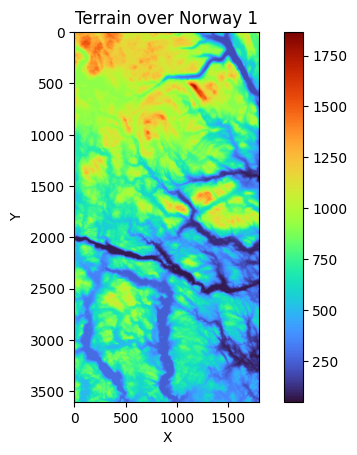

In [74]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap = "turbo")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.show()

In [186]:
terrain1.shape

(3601, 1801)

The dataset is a grid of dimension 3601x1801.

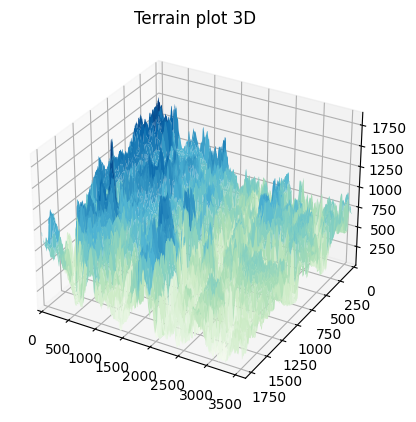

In [197]:
# Represent the entire dataset in a 3D plot, with colors according to the height of the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(3601), range(1801))
surf = ax.plot_surface(x.T, y.T, terrain1, cmap = "GnBu")
ax.set_xlim(0, 3601)
ax.set_ylim(1801, 0)
plt.title("Terrain plot 3D")
plt.savefig("Terrain plot 3D.png")
plt.show()

In [300]:
#create design matrix
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2)/n

def rsquare(y, ypredict):
    return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))

# Define a function which applies min-mas scaling
def min_max_scaling(x):
    return (x-min(x))/(max(x)-min(x))

We decided to apply min-max scaling in order to tramsform all of our data in values between 0 and 1. In this way, all the data that we have can be compared without problems of any kind.

In [301]:
# Select at random 1500 points from the entire set of points (there are too many points and otherwise the models will be very slow)
num_points = 1500
points = np.zeros([num_points, 2])
points = np.column_stack((np.random.randint(0, terrain1.shape[0], size = 1500), np.random.randint(0, terrain1.shape[1], size = 1500)))

# The z vector now contains only the values relative to the 1500 randomly selected point
z = np.zeros([num_points, 1])
for i in range(num_points):
    z[i] = terrain1[int(points[i,0])][int(points[i,1])]

# Scale the data
z = min_max_scaling(z)

points = np.column_stack((min_max_scaling(points[:,0]), min_max_scaling(points[:,1])))

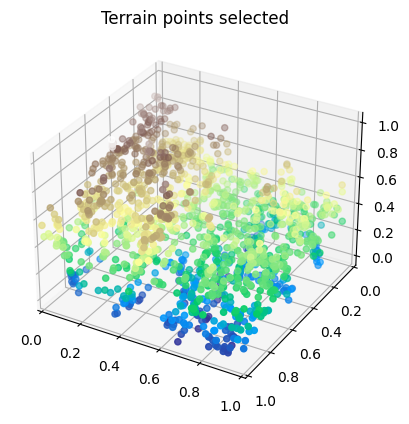

In [305]:
# Represent the selected points into a 3D scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, y = np.meshgrid(range(3601), range(1801))
ax.scatter(points[:,0], points[:,1], z, cmap = "terrain", c = z) # Create a scatterplot with colors according to the height of the point
plt.title("Terrain points selected")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.savefig("Terrain points selected.png")
plt.show()

**OLS**

<Figure size 640x480 with 0 Axes>

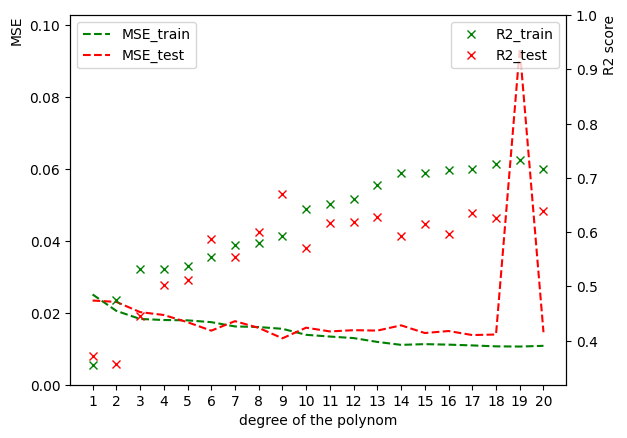

In [327]:
maxdegree = 20

MSE_train = np.zeros(maxdegree)
MSE_test = np.zeros(maxdegree)
rsqr_train = np.zeros(maxdegree)
rsqr_test = np.zeros(maxdegree)

# Apply OLS for all the degrees from 1 to 20
for i in range(1, maxdegree + 1):
        c = int((i+2)*(i+1)/2)
        poly = PolynomialFeatures(degree = maxdegree + 1)
        points_fit = poly.fit_transform(points)

        # Split in train and test data
        x_train, x_test, z_train, z_test = train_test_split(points_fit, z, test_size = 0.2)

        # Find the beta
        X_tilde = x_train[:, 0:c-1]
        beta = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ z_train

        # Make the prediction
        ypredict = X_tilde @ beta 
        ypredict_test = x_test[:,0:c-1] @ beta
        
        # Calculate MSE and R2
        MSE_train[i-1] = MSE(z_train, ypredict)
        MSE_test[i-1] = MSE(z_test, ypredict_test)
        rsqr_train[i-1]= rsquare(z_train, ypredict)
        rsqr_test[i-1]= rsquare(z_test, ypredict_test)

# plotting the MSE and R^2 as functions of the polynomial degree
fig = plt.figure()

fig2, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, maxdegree + 1)
plt.xticks(xax)
ax2 = ax1.twinx()
ax2.set_ylim(np.min(rsqr_train)*0.9, 1)
ax1.set_ylim(0, np.max(MSE_test)*1.1)
ax1.plot(xax, MSE_train, 'g--', label='MSE_train')
ax1.plot(xax, MSE_test, 'r--', label='MSE_test')
ax2.plot(xax, rsqr_train, 'gx', label='R2_train')
ax2.plot(xax, rsqr_test, 'rx', label='R2_test')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('MSE', loc='top')
ax2.set_ylabel('R2 score', loc='top')
plt.show()

**Ridge**

For ridge and Lasso we use a polynomial of degree 15.

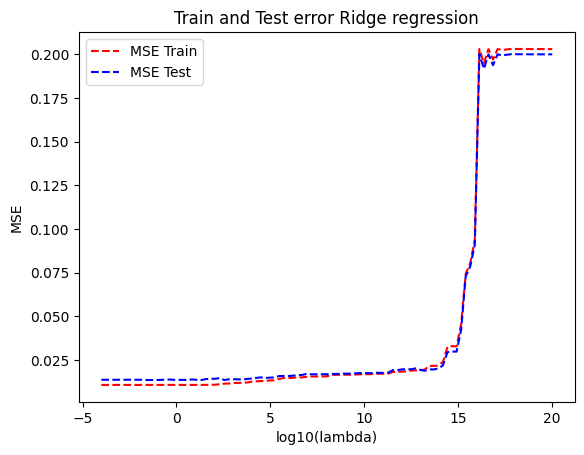

In [335]:
nlambdas = 100
lambdas = np.logspace(-4, 20, nlambdas)

MSE_train = np.zeros(nlambdas)
MSE_test = np.zeros(nlambdas)
rsqr_train = np.zeros(nlambdas)
rsqr_test = np.zeros(nlambdas)

# Split in train and test data
x_train, x_test, z_train, z_test = train_test_split(points_fit, z, test_size = 0.2)

for j in range(nlambdas):
    X_tilde = x_train[:,0:int((maxdegree+2)*(maxdegree+1)/2)]
    beta = np.linalg.pinv(X_tilde.T @ X_tilde + lambdas[j]*np.ones((len(X_tilde.T),len(X_tilde.T)))) @ X_tilde.T @ z_train
            
    ypredict = X_tilde @ beta
    ypredict_test = x_test[:,0:int((maxdegree+2)*(maxdegree+1)/2)] @ beta

    MSE_train[j] = MSE(z_train, ypredict)
    MSE_test[j] = MSE(z_test, ypredict_test)
    rsqr_train[j]= rsquare(z_train, ypredict)
    rsqr_test[j]= rsquare(z_test, ypredict_test)

plt.figure()
plt.plot(np.log10(lambdas), MSE_train, 'r--', label = 'MSE Train')
plt.plot(np.log10(lambdas), MSE_test, 'b--', label = 'MSE Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Train and Test error Ridge regression')
plt.legend()
plt.savefig("Train and Test error Ridge.png")
plt.show()

**Lasso**

c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.160e-02, tolerance: 4.582e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.441e-03, tolerance: 4.582e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

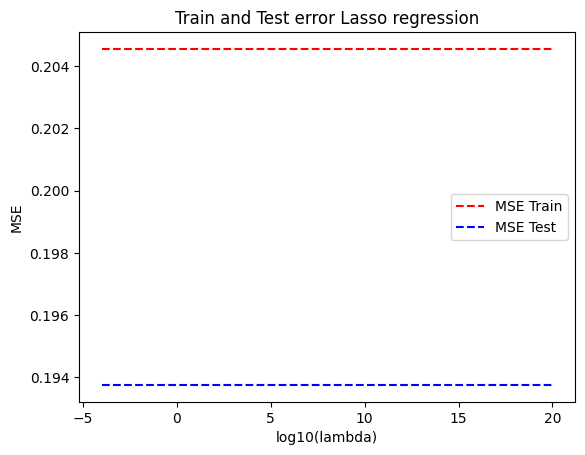

In [336]:
nlambdas = 100
lambdas = np.logspace(-4, 20, nlambdas)

MSE_train = np.zeros(nlambdas)
MSE_test = np.zeros(nlambdas)
rsqr_train = np.zeros(nlambdas)
rsqr_test = np.zeros(nlambdas)

# Split in train and test data
x_train, x_test, z_train, z_test = train_test_split(points_fit, z, test_size = 0.2)

for j in range(nlambdas):
    poly = PolynomialFeatures(degree = maxdegree + 1)
    points_fit = poly.fit_transform(points)

    X_tilde = x_train[:,0:int((maxdegree+2)*(maxdegree+1)/2)]
    
    RegLasso = linear_model.Lasso(lambdas[j])
    RegLasso.fit(X_tilde,z_train)

    ypredict_Lasso = RegLasso.predict(X_tilde)
    ypredict_test_Lasso = RegLasso.predict(x_test[:, 0:int((maxdegree+2)*(maxdegree+1)/2)])

    MSE_train[j] = MSE(z_train, ypredict)
    MSE_test[j] = MSE(z_test, ypredict_test)
    rsqr_train[j]= rsquare(z_train, ypredict)
    rsqr_test[j]= rsquare(z_test, ypredict_test)

plt.figure()
plt.plot(np.log10(lambdas), MSE_train, 'r--', label = 'MSE Train')
plt.plot(np.log10(lambdas), MSE_test, 'b--', label = 'MSE Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Train and Test error Lasso regression')
plt.legend()
plt.savefig("Train and Test error Lasso.png")
plt.show()